In [1]:
from core import *
import requests, json

In [2]:
dataset_id = {
    'all': 'd_afd0307af680e0cf96afe57193cde0c3', 
}
dataset_mode = 'all'

In [3]:
response = requests.get(
    'https://data.gov.sg/api/action/datastore_search', 
    params={
        'resource_id': dataset_id[dataset_mode],
        'limit': 999
    }
)
print(json.dumps(response.json(), indent=2))

{
  "help": "https://data.gov.sg/api/3/action/help_show?name=datastore_search",
  "success": true,
  "result": {
    "resource_id": "d_afd0307af680e0cf96afe57193cde0c3",
    "fields": [
      {
        "type": "text",
        "id": "DataSeries"
      },
      {
        "type": "numeric",
        "id": "2024"
      },
      {
        "type": "numeric",
        "id": "2023"
      },
      {
        "type": "numeric",
        "id": "2022"
      },
      {
        "type": "numeric",
        "id": "2021"
      },
      {
        "type": "numeric",
        "id": "2020"
      },
      {
        "type": "numeric",
        "id": "2019"
      },
      {
        "type": "numeric",
        "id": "2018"
      },
      {
        "type": "numeric",
        "id": "2017"
      },
      {
        "type": "numeric",
        "id": "2016"
      },
      {
        "type": "numeric",
        "id": "2015"
      },
      {
        "type": "numeric",
        "id": "2014"
      },
      {
        "type": "numeri

In [4]:
data = response.json()
records = data['result']['records']
df = pd.DataFrame(records)
df['DataSeries'] = df['DataSeries'].str.strip()
df['SubDataSeries'] = df['DataSeries'].where(df['DataSeries'].str.contains(r'(?i)\b(?:single|married|widowed|divorced)\b')).fillna('Total').str.strip()
df['DataSeries'] = df['DataSeries'].where(df['DataSeries'].str.startswith(('Total', 'Male', 'Female', ))).ffill()
df[['DataSeries', 'SubSubDataSeries']] = df['DataSeries'].str.extract(r'(?i)\b(total|male|female)s?\b.*?\b(\d+.*)\b', expand=True)
df['DataSeries'] = df['DataSeries'].str.strip()
df['SubSubDataSeries'] = df['SubSubDataSeries'].str.replace(r'(?i)\W*\byears?\b', '', regex=True).str.replace(r'(?i)\W*over\b', '+', regex=True).str.strip()
df = df.rename(columns={'DataSeries': 'gender', 'SubDataSeries': 'marital_status', 'SubSubDataSeries': 'age_group'}).drop(columns=['_id'])
df['gender'] = pd.Categorical(df['gender'], ['Female', 'Male', 'Total'], ordered=False)
df['marital_status'] = pd.Categorical(df['marital_status'], ['Single', 'Married', 'Divorced/Separated', 'Widowed', 'Total'], ordered=True)
df['age_group'] = pd.Categorical(df['age_group'], ['20-29', '30-39', '40-49', '50-59', '60-69', '70+', 'Total'], ordered=True)
for col in df.drop(columns=['gender', 'marital_status', 'age_group']).columns:
    try:
        df[col] = df[col].astype('int')
    except:
        df[col] = df[col].str.strip().astype('int')
df = df.groupby(by=['gender', 'marital_status', 'age_group'], observed=True).sum()
df = pd.concat([
    df, 
    df.rename(index=lambda _: 'Total', level='age_group').groupby(by=['gender', 'marital_status', 'age_group'], observed=True).sum()
], axis=0)
df = df.rename(columns=int).astype('int').transpose().sort_index(axis=0).sort_index(axis=1).copy(deep=True)
assert isinstance(df, pd.DataFrame)
display_all_columns(df)

gender          Female                                                     \
marital_status  Single                                            Married   
age_group        20-29  30-39  40-49  50-59  60-69    70+   Total   20-29   
1980            136100  21300   5700   2200   2500   2000  169800  109000   
1983            158400  29200   5500   2200   1600   1800  198700  107100   
1984            156300  32300   6500   2600   1900   1900  201500  106200   
1985            160600  34500   7200   2500   1800   1800  208400  100800   
1986            161700  36300   7800   3200   1600   2000  212600   99800   
1987            159800  38400   7900   3300   1200   1200  211800  104200   
1988            158900  41100   9200   3300   1600   1500  215600   95900   
1989            160700  40100   9300   4100   1900   1800  217900   93400   
1990            144400  48400  16200   5400   2100   2600  219100  106500   
1991            149800  47500  17800   5600   2300   1800  224800  100200   
1992            156000  49300  19200   6000   2100   1900  234500   99600   
1993            153900  50200  19700   5700   2300   1700  233500   90400   
1994            153300  49300  22600   6500   2500   1800  236000   97400   
1995            142100  52000  28000   7200   2600   1700  233600   88600   
1996            142900  54000  27500   9800   3200   1100  238500   95000   
1997            147500  50400  31600   9800   3600   1700  244600   92900   
1998            141400  52800  36800  11700   3600   2000  248300   88900   
1999            140900  49500  37400  13700   4900   2400  248800   93600   
2000            137200  51400  36600  15100   4700   1900  246900   93700   
2001            138800  50900  38600  16300   5100   3300  253000   88700   
2002            146200  51500  39400  21400   5400   2900  266800   78200   
2003            145000  57900  40500  24500   7300   2800  278000   78900   
2004            150900  53100  38400  24400   7000   3200  277000   73700   
2005            147000  57200  42400  26300   6900   2700  282500   79000   
2006            158400  58200  41300  27800   9100   3900  298700   69800   
2007            158300  57600  41300  31100  10100   3600  302000   69500   
2008            160700  60500  37800  29700   9800   3600  302100   66100   
2009            169800  61600  39700  32700  12200   4600  320600   64000   
2010            181100  66800  42500  34500  13400   4800  343100   68500   
2011            189100  64300  42700  35200  14300   5500  351100   57500   
2012            192800  63600  40900  33700  17700   6800  355500   52800   
2013            191100  67800  43800  38100  19800   6700  367300   50000   
2014            203800  66800  45100  41300  24100   8300  389400   44800   
2015            197500  63900  47600  38300  23600   7800  378700   49300   
2016            205200  64300  44200  39000  28800   7700  389200   52600   
2017            193200  67000  47600  39900  27900   9900  385500   49700   
2018            201200  65200  45300  40300  30700  11700  394400   48900   
2019            198000  70400  48100  39300  31300  12100  399200   46000   
2020            212400  82300  50800  40700  31400  13600  431200   47600   
2021            195900  92600  55900  36500  34700  17500  433100   43200   
2022            168900  79100  56900  42300  36700  18000  401900   36300   
2023            188600  84400  49400  41000  30900  17300  411600   39000   
2024            181900  86700  48200  37700  35400  22400  412300   32900   

gender                                                           \
marital_status                                                    
age_group        30-39   40-49   50-59   60-69     70+    Total   
1980            132100   95900   54900   26000    7900   425800   
1983            152200  108900   65700   28800   10300   473000   
1984            166900  115500   69400   32200   13800   504000   
1985            177500  114600   73100   32600   13000 

In [5]:
df_pct = df.copy(deep=True)
df_pct = df_pct.apply(lambda row: row.div(row.xs('Total', 0, 'marital_status')), axis=1).drop(columns=['Total'], level='marital_status').sort_index(axis=1)
display_all_columns(df_pct)

gender            Female                                                    \
marital_status    Single                                                     
age_group          20-29     30-39     40-49     50-59     60-69       70+   
1980            0.550789  0.134131  0.050532  0.028461  0.046041  0.054795   
1983            0.593036  0.156989  0.043895  0.024915  0.028623  0.043796   
1984            0.591821  0.157407  0.048799  0.028603  0.032986  0.042316   
1985            0.609719  0.157750  0.053933  0.025641  0.030151  0.041002   
1986            0.613895  0.158723  0.056156  0.031873  0.025890  0.041494   
1987            0.601657  0.161277  0.055517  0.032039  0.019169  0.025105   
1988            0.618047  0.163550  0.059896  0.030957  0.024316  0.032680   
1989            0.627980  0.159888  0.057800  0.035590  0.026279  0.035019   
1990            0.568728  0.180799  0.098780  0.049770  0.029046  0.043478   
1991            0.594917  0.175147  0.095750  0.046205  0.030626  0.030457   
1992            0.605825  0.177211  0.098462  0.047133  0.026515  0.032040   
1993            0.625356  0.176823  0.093765  0.043914  0.027578  0.028716   
1994            0.606408  0.168259  0.104004  0.048689  0.029070  0.028571   
1995            0.610657  0.174438  0.118393  0.056382  0.028509  0.024355   
1996            0.597158  0.176702  0.108524  0.075910  0.035635  0.015363   
1997            0.610008  0.167386  0.120106  0.067773  0.038751  0.022942   
1998            0.610272  0.173228  0.133140  0.076521  0.037306  0.024814   
1999            0.597034  0.163690  0.135164  0.085786  0.046890  0.029703   
2000            0.588084  0.172194  0.130761  0.091184  0.045587  0.022837   
2001            0.605849  0.165421  0.134308  0.095210  0.046661  0.036184   
2002            0.647476  0.165701  0.132973  0.112101  0.046997  0.030917   
2003            0.640177  0.187439  0.134106  0.118874  0.058635  0.027778   
2004            0.665051  0.176823  0.123791  0.111619  0.057471  0.030681   
2005            0.643045  0.184814  0.137797  0.114248  0.059329  0.025714   
2006            0.686606  0.190258  0.127627  0.113331  0.070054  0.033505   
2007            0.687364  0.186649  0.126571  0.121722  0.074265  0.029925   
2008            0.699608  0.196684  0.119205  0.115072  0.068293  0.030691   
2009            0.717667  0.193772  0.124647  0.123071  0.077608  0.035604   
2010            0.716377  0.209470  0.134409  0.124369  0.084224  0.036009   
2011            0.758220  0.207286  0.133146  0.121129  0.084665  0.038435   
2012            0.778047  0.208320  0.126040  0.114548  0.096880  0.046639   
2013            0.785773  0.223984  0.135730  0.125370  0.102697  0.043934   
2014            0.815526  0.224764  0.144228  0.132118  0.110754  0.050181   
2015            0.792854  0.210267  0.149123  0.124351  0.106163  0.048387   
2016            0.791056  0.218931  0.139476  0.124006  0.122137  0.045267   
2017            0.789861  0.221561  0.144945  0.134615  0.114391  0.052326   
2018            0.799682  0.216252  0.139815  0.130505  0.124797  0.061129   
2019            0.806517  0.231047  0.145713  0.121936  0.126978  0.060561   
2020            0.810069  0.260361  0.158651  0.132358  0.118894  0.062072   
2021            0.815231  0.278832  0.176731  0.129387  0.123840  0.083652   
2022            0.817126  0.247419  0.158408  0.136672  0.132062  0.077653   
2023            0.823221  0.265827  0.150198  0.125000  0.109497  0.069117   
2024            0.841740  0.271872  0.146282  0.120409  0.118912  0.080057   

gender                                                                      \
marital_status             Married                                           
age_group          Total     20-29     30-39     40-49     50-59     60-69   
1980            0.247234  0.441117  0.831864  0.850177  0.710220  0.478821   
1983            0.260181  0.400973  0.818280  0.869114  0.744054  0.515206   
1984            0.253

In [6]:
df_cohort = df_pct.rename_axis(index='year').drop(columns=['Total'], level='age_group').stack(level=['age_group', 'gender']).reset_index(drop=False).copy(deep=True)
df_cohort['cohort'] = df_cohort['age_group'].str.extract(r'(?i)(\d+)')
df_cohort['cohort'] = df_cohort['year'].subtract(df_cohort['cohort'].astype('int')).map(lambda val: f'{val-9:.0f}-{val:.0f}')
for col in ['age_group']:
    df_cohort[col] = pd.Categorical(df_cohort[col], df_cohort[col].sort_values().unique(), ordered=True)
df_cohort = df_cohort.drop(columns=['year']).set_index(keys=['cohort', 'gender', 'age_group'], append=False).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
df_cohort = df_cohort.T.reset_index(drop=False)
df_cohort['marital_status'] = pd.Categorical(df_cohort['marital_status'], ['Single', 'Married', 'Divorced/Separated', 'Widowed'], ordered=True)
df_cohort = df_cohort.set_index(keys=['marital_status']).T.copy(deep=True)
df_cohort = df_cohort.T.stack(level=['age_group']).unstack(level=['marital_status']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
display_all_columns(df_cohort)

/tmp/ipykernel_16424/2279710072.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cohort = df_pct.rename_axis(index='year').drop(columns=['Total'], level='age_group').stack(level=['age_group', 'gender']).reset_index(drop=False).copy(deep=True)
/tmp/ipykernel_16424/2279710072.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cohort = df_cohort.T.stack(level=['age_group']).unstack(level=['marital_status']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)


cohort         1901-1910                                                  \
gender            Female                                            Male   
marital_status    Single   Married Divorced/Separated   Widowed   Single   
age_group                                                                  
20-29                NaN       NaN                NaN       NaN      NaN   
30-39                NaN       NaN                NaN       NaN      NaN   
40-49                NaN       NaN                NaN       NaN      NaN   
50-59                NaN       NaN                NaN       NaN      NaN   
60-69                NaN       NaN                NaN       NaN      NaN   
70+             0.054795  0.216438           0.005479  0.723288  0.04797   

cohort                                                                     \
gender                                                    Total             
marital_status   Married Divorced/Separated   Widowed    Single   Married   
age_group                                                                   
20-29                NaN                NaN       NaN       NaN       NaN   
30-39                NaN                NaN       NaN       NaN       NaN   
40-49                NaN                NaN       NaN       NaN       NaN   
50-59                NaN                NaN       NaN       NaN       NaN   
60-69                NaN                NaN       NaN       NaN       NaN   
70+             0.704797            0.01107  0.236162  0.051969  0.425197   

cohort                                      1904-1913            \
gender                                         Female             
marital_status Divorced/Separated   Widowed    Single   Married   
age_group                                                         
20-29                         NaN       NaN       NaN       NaN   
30-39                         NaN       NaN       NaN       NaN   
40-49                         NaN       NaN       NaN       NaN   
50-59                         NaN       NaN       NaN       NaN   
60-69                         NaN       NaN       NaN       NaN   
70+                      0.007874  0.516535  0.043796  0.250608   

cohort                                                         \
gender                                           Male           
marital_status Divorced/Separated   Widowed    Single Married   
age_group                                                       
20-29                         NaN       NaN       NaN     NaN   
30-39                         NaN       NaN       NaN     NaN   
40-49                         NaN       NaN       NaN     NaN   
50-59                         NaN       NaN       NaN     NaN   
60-69                         NaN       NaN       NaN     NaN   
70+                           0.0  0.703163  0.028846    0.75   

cohort                                                           \
gender                                          Total             
marital_status Divorced/Separated   Widowed    Single   Married   
age_group                                                         
20-29                         NaN       NaN       NaN       NaN   
30-39                         NaN       NaN       NaN       NaN   
40-49                         NaN       NaN       NaN       NaN   
50-59                         NaN       NaN       NaN       NaN   
60-69                         NaN       NaN       NaN       NaN   
70+                      0.003205  0.214744  0.037396  0.466759   

cohort                                     1905-1914           \
gender                                        Female            
marital_status Divorced/Separated  Widowed    Single  Married   
age_group                                                       
20-29                         NaN      NaN       NaN      NaN   
30-39                         NaN      NaN       NaN      NaN   
40-49                         NaN      NaN       NaN      NaN   
50-59               

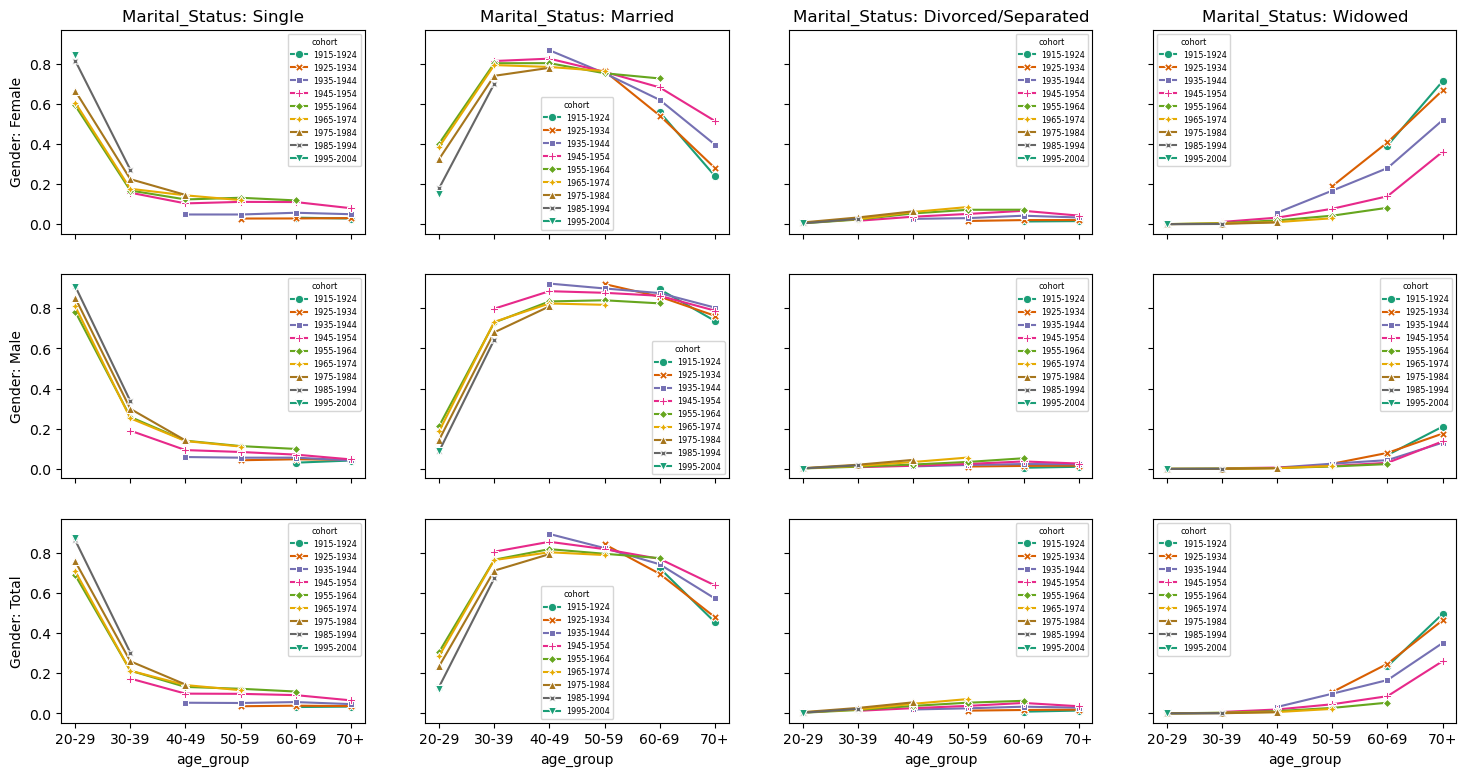

In [7]:
fig, axs = plot_multicol_data(df_cohort.loc[:,df_cohort.xs(('Female', 'Married', ), 1, ('gender', 'marital_status', )).iloc[:,-81::10].columns], x_level='gender', y_level='marital_status')
fig.savefig(f'./cohort_{dataset_mode}.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()

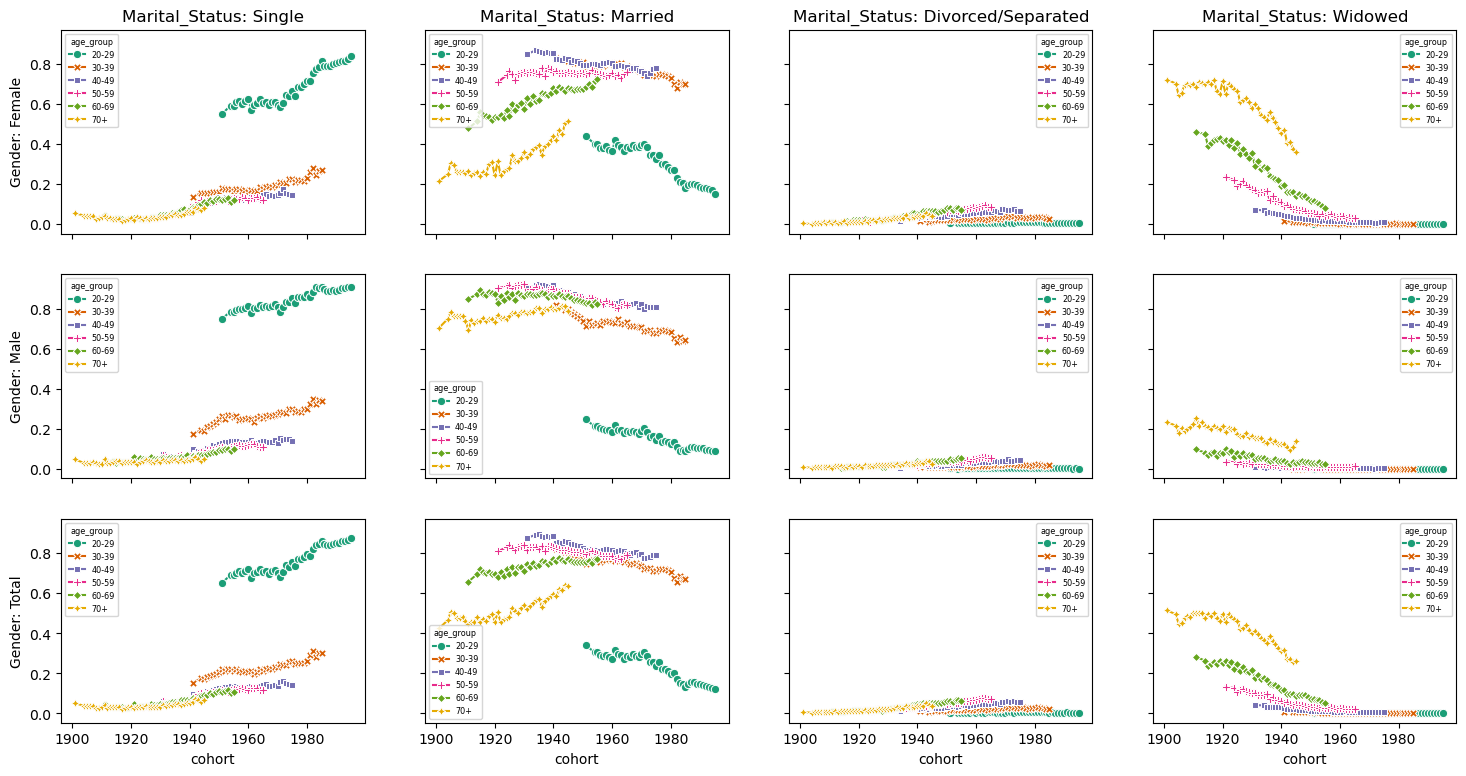

In [8]:
fig, axs = plot_multicol_data(df_cohort.T.unstack(level=['gender', 'marital_status']).sort_index(axis=1).sort_index(axis=0).rename(index=lambda val: int(val.split('-')[0])), x_level='gender', y_level='marital_status')
# fig.savefig(f'./agegroup_{dataset_mode}.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()